In [5]:
%matplotlib inline

In [6]:
import datajoint as dj
schema = dj.schema('university')
schema.spawn_missing_classes()

/Users/dimitri/dev/datajoint-python/datajoint/connection.py:268: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


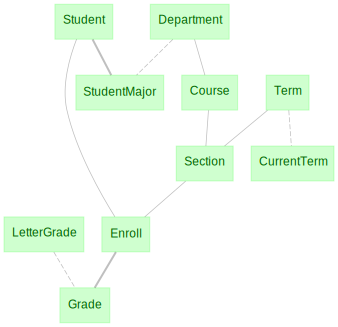

In [7]:
dj.Diagram(schema)

In [8]:
schema.database

'university'

# Generate fake data

In [9]:
# Cleanup from previous run
with dj.config(safemode=False):
    Department.delete()
    Student.delete()
    LetterGrade.delete()
    Term.delete()

Deleting 0 rows from `university`.`department`
Deleting 0 rows from `university`.`student`
Deleting 0 rows from `university`.`letter_grade`
Deleting 0 rows from `university`.`term`


In [10]:
from tqdm import tqdm
import faker
import random
import itertools
import datetime
fake = faker.Faker()
faker.Faker.seed(42)
random.seed(42)

## Students

In [11]:
def yield_students():
    fake_name = {'F': fake.name_female, 'M': fake.name_male}
    while True:  # ignore invalid values
        try:
            sex = random.choice(('F', 'M'))
            first_name, last_name = fake_name[sex]().split(' ')[:2]
            street_address, city = fake.address().split('\n')
            city, state = city.split(', ')
            state, zipcode = state.split(' ')            
        except ValueError:
            continue
        else:
            yield dict(
                first_name=first_name,
                last_name=last_name,
                sex=sex,
                home_address=street_address,
                home_city=city,
                home_state=state,
                home_zip=zipcode,
                date_of_birth=str(
                    fake.date_time_between(start_date="-35y", end_date="-15y").date()),
                home_phone = fake.phone_number()[:20])

In [12]:
Student.insert(
    dict(k, student_id=i) for i, k in zip(range(100,400), yield_students()))

## Departments, majors, and courses

In [13]:
Student()

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
100,Allison,Hill,F,1991-06-04,819 Anthony Fields Suite 083,Jacquelinebury,IN,01352,+1-542-351-1615
101,Lindsey,Roman,F,1995-06-13,618 Courtney Tunnel Apt. 310,Kendrashire,UT,50324,(525)534-1928x327
102,William,Bowman,M,2005-02-02,030 Morales Centers Suite 953,Randallside,IL,32826,(969)653-2871x01226
103,Janice,Carlson,F,1989-08-11,0184 Peterson Green,North Jenniferchester,PA,67043,+1-489-325-2880x9570
104,Sherry,Decker,F,2004-05-04,117 Spence Mountain,New Staceyville,NJ,28261,001-346-578-7133
105,Alisha,Spencer,F,1994-04-04,031 Heath Circle,New Jasonland,NH,62454,+1-631-165-6670x106
106,Rebecca,Rodriguez,F,1987-12-26,24731 Michelle Orchard Apt. 801,Allisonville,GA,53066,(064)746-8723
107,Tracy,Riley,F,2005-03-22,97882 William Summit Apt. 136,Port Johnstad,MA,77004,(435)346-2475x10799
108,Mr.,Daniel,M,1995-07-30,2784 Archer Ports Apt. 841,Taylorland,NV,36198,534.874.0164x0052
109,Deborah,Figueroa,F,1994-06-24,12805 Hernandez Creek,Port Laura,VT,28036,586.923.2260x25634


In [14]:
Department.insert(
    dict(dept=dept, 
         dept_name=name, 
         dept_address=fake.address(), 
         dept_phone=fake.phone_number()[:20])
    for dept, name in [
        ["CS", "Computer Science"],
        ["BIOL", "Life Sciences"],
        ["PHYS", "Physics"],
        ["MATH", "Mathematics"]])

In [15]:
StudentMajor.insert({**s, **d, 
                     'declare_date':fake.date_between(start_date=datetime.date(1999,1,1))}
    for s, d in zip(Student.fetch('KEY'), random.choices(Department.fetch('KEY'), k=len(Student())))
                   if random.random() < 0.75)

In [16]:
# from https://www.utah.edu/
Course.insert([
    ['BIOL', 1006, 'World of Dinosaurs', 3],
    ['BIOL', 1010, 'Biology in the 21st Century', 3],
    ['BIOL', 1030, 'Human Biology', 3],
    ['BIOL', 1210, 'Principles of Biology', 4],
    ['BIOL', 2010, 'Evolution & Diversity of Life', 3],
    ['BIOL', 2020, 'Principles of Cell Biology',  3],
    ['BIOL', 2021, 'Principles of Cell Science',  4],
    ['BIOL', 2030, 'Principles of Genetics',  3],
    ['BIOL', 2210, 'Human Genetics',3],
    ['BIOL', 2325, 'Human Anatomy', 4],
    ['BIOL', 2330, 'Plants & Society', 3],
    ['BIOL', 2355, 'Field Botany', 2],
    ['BIOL', 2420, 'Human Physiology', 4],

    ['PHYS', 2040, 'Classcal Theoretical Physics II', 4],
    ['PHYS', 2060, 'Quantum Mechanics', 3],
    ['PHYS', 2100, 'General Relativity and Cosmology', 3],
    ['PHYS', 2140, 'Statistical Mechanics', 4],
    
    ['PHYS', 2210, 'Physics for Scientists and Engineers I', 4], 
    ['PHYS', 2220, 'Physics for Scientists and Engineers II', 4],
    ['PHYS', 3210, 'Physics for Scientists I (Honors)', 4],
    ['PHYS', 3220, 'Physics for Scientists II (Honors)', 4],
    
    ['MATH', 1250, 'Calculus for AP Students I', 4],
    ['MATH', 1260, 'Calculus for AP Students II', 4],
    ['MATH', 1210, 'Calculus I', 4],
    ['MATH', 1220, 'Calculus II', 4],
    ['MATH', 2210, 'Calculus III', 3],
 
    ['MATH', 2270, 'Linear Algebra', 4],
    ['MATH', 2280, 'Introduction to Differential Equations', 4],
    ['MATH', 3210, 'Foundations of Analysis I', 4],
    ['MATH', 3220, 'Foundations of Analysis II', 4],
    
    ['CS', 1030, 'Foundations of Computer Science', 3],
    ['CS', 1410, 'Introduction to Object-Oriented Programming', 4],
    ['CS', 2420, 'Introduction to Algorithms & Data Structures', 4],
    ['CS', 2100, 'Discrete Structures', 3],
    ['CS', 3500, 'Software Practice', 4],
    ['CS', 3505, 'Software Practice II', 3],
    ['CS', 3810, 'Computer Organization', 4],
    ['CS', 4400, 'Computer Systems', 4],
    ['CS', 4150, 'Algorithms', 3],
    ['CS', 3100, 'Models of Computation', 3],
    ['CS', 3200, 'Introduction to Scientific Computing', 3],
    ['CS', 4000, 'Senior Capstone Project - Design Phase', 3],
    ['CS', 4500, 'Senior Capstone Project', 3],
    ['CS', 4940, 'Undergraduate Research', 3],
    ['CS', 4970, 'Computer Science Bachelor''s Thesis', 3]])

## Terms and course sections

In [17]:
Term.insert(dict(term_year=year, term=term) 
            for year in range(2015, 2021) 
            for term in ['Spring', 'Summer', 'Fall'])

Term().fetch(order_by=('term_year DESC', 'term DESC'), as_dict=True, limit=1)[0]

CurrentTerm().insert1({
    'omega': 1, 
    **Term().fetch(order_by=('term_year DESC', 'term DESC'), as_dict=True, limit=1)[0]})

def make_section(prob):
    for c in (Course * Term).proj():
        for sec in 'abcd':
            if random.random() < prob:
                break
            yield {
                **c, 'section': sec, 
                'auditorium': random.choice('ABCDEF') + str(random.randint(1,100))}   

Section.insert(make_section(0.5))

In [18]:
Section()

"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,auditorium
BIOL,1006,2015,Fall,a,C68
BIOL,1006,2015,Fall,b,C22
BIOL,1006,2016,Spring,a,D38
BIOL,1006,2016,Spring,b,C15
BIOL,1006,2016,Fall,a,B87
BIOL,1006,2016,Fall,b,D72
BIOL,1006,2017,Spring,a,A34
BIOL,1006,2017,Spring,b,D48
BIOL,1006,2017,Spring,c,F34
BIOL,1006,2017,Spring,d,F48


In [19]:
LetterGrade.insert([
    ['A',  4.00],
    ['A-', 3.67],
    ['B+', 3.33],
    ['B',  3.00],
    ['B-', 2.67],
    ['C+', 2.33],
    ['C',  2.00],
    ['C-', 1.67],
    ['D+', 1.33],
    ['D',  1.00],
    ['F',  0.00]])

## Enrollment and grades

In [20]:
terms = Term().fetch('KEY')
quit_prob = 0.1
for student in tqdm(Student.fetch('KEY')):
    start_term = random.randrange(len(terms))
    for term in terms[start_term:]:
        if random.random() < quit_prob:
            break
        else:
            sections = ((Section & term) - (Course & (Enroll & student))).fetch('KEY')
            if sections:
                Enroll.insert({**student, **section} for section in 
                              random.sample(sections, random.randrange(min(5, len(sections)))))

100%|██████████| 300/300 [00:08<00:00, 35.93it/s]


In [21]:
# assign random grades
grades = LetterGrade.fetch('grade')

In [22]:
grade_keys = Enroll.fetch('KEY')
random.shuffle(grade_keys)
grade_keys = grade_keys[:len(grade_keys)*9//10]

In [23]:
Grade.insert({**key, 'grade':grade} 
             for key, grade in zip(grade_keys, random.choices(grades, k=len(grade_keys))))

In [24]:
Grade()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,grade
101,PHYS,2220,2017,Fall,c,A
102,BIOL,2210,2020,Summer,a,A
103,BIOL,1010,2019,Fall,c,A
108,CS,4000,2018,Summer,a,A
108,CS,4400,2016,Summer,c,A
111,PHYS,2140,2019,Summer,a,A
111,PHYS,2210,2020,Summer,b,A
111,PHYS,2220,2017,Fall,d,A
115,BIOL,1010,2019,Spring,c,A
115,MATH,1260,2020,Spring,b,A


In [25]:
(Enroll + Grade.proj())

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section
353,BIOL,1006,2015,Fall,a
176,BIOL,1006,2015,Fall,b
198,BIOL,1006,2015,Fall,b
200,BIOL,1006,2015,Fall,b
231,BIOL,1006,2015,Fall,b
344,BIOL,1006,2015,Fall,b
190,BIOL,1006,2016,Spring,a
277,BIOL,1006,2016,Spring,a
290,BIOL,1006,2016,Spring,a
258,BIOL,1006,2016,Spring,b
